In [ ]:
!git clone https://github.com/Shiny-HKLab/GenerativeAIDevelopmentSeminarDocumentation.git
%cd GenerativeAIDevelopmentSeminarDocumentation/section04-practical-gemini-api
!ls images

In [14]:
import os

from dotenv import load_dotenv

load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
model_id = "gemini-2.0-flash"
assert GOOGLE_API_KEY is not None

### 環境変数の設定（Google Colabの場合）

1. Google ColabのシークレットタブからGoogle APIキーの「Google AI Studioでキーを管理」という項目をクリックしてGemini APIキーの管理画面に移動します
2. 管理画面から「APIキーの作成」を行い、APIキーを追加します
3. Google Colabに戻り、シークレットタブからGoogle APIキーの「Google AI Studioからキーをインポート」をクリックして先ほど追加したAPIキーを選択します
4. シークレットタブに「GOOGLE_API_KEY」という名前が追加されているのを確認したら以下のセルを実行し、エラーが発生しないことを確認してください

In [ ]:
from google.colab import userdata

GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")
assert GOOGLE_API_KEY is not None

#### 【復習】　チャット機能で会話の文脈を管理する
ユーザーから入力を受け取り、英語だった場合は日本語で回答し、日本語だったら英語で回答する

In [2]:
from google import genai
from google.genai import types

system_message = """
# あなたの役割
あなたは、ユーザーの入力言語を判断し、指定された反対の言語で回答する優秀なアシスタントです。

## 行動ルール
- ユーザーからの入力を受け取ったら、まずその言語が「日本語」か「英語」かを判断してください。
- 入力が日本語の場合： 回答のすべてを英語で生成してください。
- 入力が英語の場合： 回答のすべてを日本語で生成してください。
"""
model_id = "gemini-2.0-flash"

client = genai.Client(api_key=GOOGLE_API_KEY)
chat = client.chats.create(
    model=model_id,
    config=types.GenerateContentConfig(
        temperature=1.0,
        system_instruction=system_message,
    )
)

In [3]:
first_prompt = "My name is Takeuchi."
first_response = chat.send_message(
    message=types.Part.from_text(text=first_prompt)
)
print(first_response.text)

私の名前は竹内です。



In [28]:
chat.get_history()

[UserContent(parts=[Part(video_metadata=None, thought=None, code_execution_result=None, executable_code=None, file_data=None, function_call=None, function_response=None, inline_data=None, text='My name is Takeuchi.')], role='user'),
 Content(parts=[Part(video_metadata=None, thought=None, code_execution_result=None, executable_code=None, file_data=None, function_call=None, function_response=None, inline_data=None, text='竹内です。初めまして。お会いできて嬉しいです。何かお手伝いできることはありますか？\n')], role='model')]

In [ ]:
for chunk in chat.send_message_stream(
    message=types.Part.from_text(text="私の名前を覚えていますか？")
):
    print(chunk.text, end="", flush=True)

Yes, I remember your name. It's Takeuchi. How can I assist you today?


### 画像についてAIで説明してもらう
Geminiは画像の内容も理解できるため、写真やイラストについてAIに説明してもらうことが可能です。（※マルチモーダル対応）

※マルチモーダルとは **AIが、人間のように複数の種類の情報を同時に理解し、処理できる能力** のことです。
例：テキスト（ユーザーの質問）＋画像

#### AIに入力として渡す画像のセットアップ

In [ ]:
import os

from IPython.display import Image, display

image_a_path = "images/luca-bravo-9l_326FISzk-unsplash.jpg"

if not os.path.exists(image_a_path):
    raise FileNotFoundError(f"Image file not found: {image_a_path}")

with open(image_a_path, "rb") as image_file:
    image_a = image_file.read()

def get_image_mime_type(image_path):
    """Get the MIME type of an image file."""
    if image_path.lower().endswith(".jpg") or image_path.lower().endswith(".jpeg"):
        return "image/jpeg"
    elif image_path.lower().endswith(".png"):
        return "image/png"
    elif image_path.lower().endswith(".gif"):
        return "image/gif"
    else:
        raise ValueError("Unsupported image format")


mime_type = get_image_mime_type(image_a_path)

# AIに入力として渡す画像を表示
display(Image(image_a_path))

In [5]:
from google.genai import types

# AIに画像について質問
response_a = client.models.generate_content(
    model=model_id,
    contents=[
        "この画像に写っているものを詳しく説明してください",
        types.Part.from_bytes(data=image_a, mime_type=mime_type),
    ],
)

print(response_a.text)

画像には、ダークブラウンのウッドトップのテーブルに置かれた開いた状態のシルバーのMacBookラップトップと、白いAppleワイヤレスマウスが写っています。ラップトップはテーブルの中央にややオフセットして置かれ、マウスはラップトップの右側にあります。画像の手前には、黒い布張りシートと白いシェルを備え、木製の脚を持つモダンなデザインの椅子の一部が見えます。この椅子はテーブルの左側に部分的に見えます。画像は全体的に暗く、落ち着いた色合いで、最小限のデザインとクリーンな美学が強調されています。全体として、この画像は、ミニマルなワークスペースまたはオフィス環境を表現しています。


#### 【演習】 先程と別の画像を使って質問する
目標：画像や設定を変更してAIの出力が変わることを確認する

手順
- 先程使用した画像とは　別の画像（images/zeynep-sumer-lk3F07BN8T8-unsplash.jpgを使用するか、Colab上でアップロードする）を読み込んで画面上に表示する
- 読み込んだ画像をAIの入力として設定し、AIに説明、推論してもらう

In [ ]:
# 画像の読み込みや設定、表示
import os

from IPython.display import Image, display


class ImagePreprocessor:
    """
    画像ファイルを管理するユーティリティクラス
    画像のパスを指定して初期化し、画像のMIMEタイプを取得したり、画像ファイルを読み込んでバイナリデータとして
    返すことができます。
    """

    def __init__(self, image_path: str):
        """
        画像のパスを指定して初期化

        Args:
            image_path (str): 画像ファイルのパス
        """
        self.image_path = image_path

    @property
    def mime_type(self) -> str:
        """
        画像のMIMEタイプを取得

        Returns:
            str: 画像のMIMEタイプ
        """
        return self._get_mime_type()

    def load_image(self) -> bytes:
        """
        画像ファイルを読み込み、バイナリデータとして返す

        Returns:
            bytes: 画像のバイナリデータ
        """
        if not os.path.exists(self.image_path):
            raise FileNotFoundError(
                f"指定された画像ファイルが見つかりません: {self.image_path}"
            )

        with open(self.image_path, "rb") as image_file:
            image_data = image_file.read()

        return image_data

    def _get_mime_type(self) -> str:
        """
        画像のMIMEタイプを返す

        Returns:
            str: 画像のMIMEタイプ
        """
        if self.image_path.lower().endswith(".png"):
            return "image/png"
        elif self.image_path.lower().endswith((".jpg", ".jpeg")):
            return "image/jpeg"
        elif self.image_path.lower().endswith(".webp"):
            return "image/webp"
        else:
            raise ValueError(
                "サポートされていない画像形式です。サポートされている形式はPNG、JPEG、WEBPです。"
            )

image_path = "images/zeynep-sumer-lk3F07BN8T8-unsplash.jpg"

# AIに入力として渡す画像を表示
display(Image(image_path))


In [19]:
from google.genai import types

model_id = "gemini-2.0-flash"
processor = ImagePreprocessor(image_path)

# AIに画像について質問
ai_response = client.models.generate_content(
    model=model_id,
    contents=[
        "この画像に写っているものを詳しく説明してください",
        types.Part.from_bytes(
            data=processor.load_image(),
            mime_type=processor.mime_type,
        ),
    ],
)

# AIの応答を表示
print(ai_response.text)


この画像は、満開のヒマワリ畑のクローズアップです。手前の大きなヒマワリに焦点が合っており、鮮やかな黄色い花びらと濃い茶色の種のある中央部がはっきりと見えます。ヒマワリは茎にしっかりと立っており、その周りには、頭を下げて花びらが茶色くなった枯れかけたヒマワリがいくつかあります。

背景には、緑の葉と黄色い花が散りばめられたヒマワリ畑が広がっており、遠くには木々の暗いシルエットが見えます。空は明るい色合いで、晴れた日であることを示唆しています。全体的な構図は、元気なヒマワリと枯れかけたヒマワリのコントラストが印象的で、生命のサイクルと季節の移り変わりを表しているようです。


#### WebAPIから画像を取得する場合の例

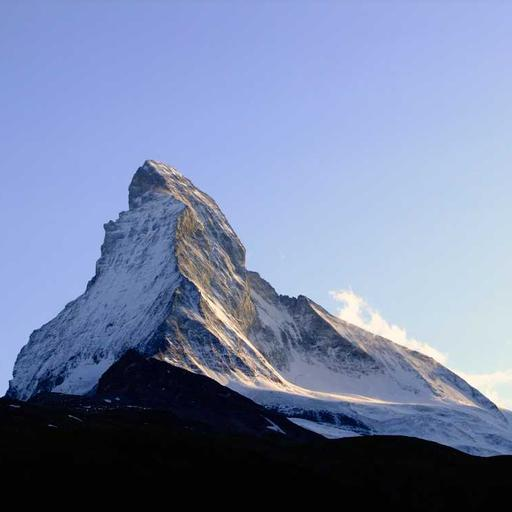

In [ ]:
import requests
from IPython.display import Image, display

url = "https://picsum.photos/512/512"

try:
    response_img = requests.get(url)
    response_img.raise_for_status()
    display(Image(data=response_img.content))
except requests.HTTPError as e:
    print(f"HTTP error occurred: {e}")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
from google.genai import types

# AIに画像について質問
response_c = client.models.generate_content(
    model=model_id,
    contents=[
        "この画像に写っているものを詳しく説明してください",
        types.Part.from_bytes(data=response_img.content, mime_type="image/jpeg"),
    ],
)

print(response_c.text)


画像は、人が点火して燃えている線香花火を手に持っている様子を捉えています。花火は明るく輝いており、周囲は暗闇に包まれています。手はかすんでいますが、線香花火の光が強く放たれていることがわかります。画像全体は、暖かく祝祭的な雰囲気を感じさせます。


#### 構造化出力
- 構造化出力は、AIモデルからの回答を予測可能で扱いやすい形式で取得するための重要な機能です。従来のテキスト応答とは異なり、JSON形式やスキーマ定義された形式での出力を保証することで、アプリケーション開発の効率性と信頼性を大幅に向上させます。
- AIモデルからの応答を事前に定義されたスキーマに従って出力させる仕組みです。これにより、開発者は応答の形式を予測でき、後続の処理を安全に実行できます。

In [15]:
from google import genai

model_id = "gemini-2.0-flash"
#　従来の応答
client = genai.Client(api_key=GOOGLE_API_KEY)

response = client.models.generate_content(
    model=model_id,
    contents="面白いSF小説を1冊おすすめしてください",
)
print(response.text)

SF小説ですね、承知いたしました。

もしよろしければ、以下の作品をおすすめします。

**テッド・チャン『あなたの人生の物語』**

**おすすめポイント:**

*   **知的興奮:** 言語学をテーマに、異星人とのコミュニケーションを通じて時間や認識の本質に迫る、非常に知的なSFです。
*   **美しい文章:** 哲学的なテーマを扱いながらも、文章が美しく、読みやすいのが特徴です。
*   **感動的な物語:** SF的な設定の中に、人間の感情や愛、運命といった普遍的なテーマが織り込まれており、心を揺さぶられます。
*   **映画化作品:** 映画『メッセージ』の原作としても知られており、映像作品としても楽しめます。

**あらすじ:**

言語学者のルイーズは、地球に飛来した異星人「ヘプタポッド」とのコミュニケーションを政府から依頼される。彼らの言語を解読していくうちに、ルイーズは時間に対する認識が変化していく。

この作品は短編集に収録されていますが、表題作である「あなたの人生の物語」は独立した長編としても読めるほどの読み応えがあります。

もし、他に好みのジャンルやテーマがあれば、そちらに合わせたおすすめもできますので、お気軽にお知らせください。



In [ ]:
from google import genai
from google.genai import types
from pydantic import BaseModel, Field

model_id = "gemini-2.0-flash"

# データ構造を定義（Fieldで詳細な説明を追加）
class BookInfo(BaseModel):
    title: str = Field(description="本のタイトル")
    author: str = Field(description="著者名")
    genre: str = Field(description="ジャンル（小説、ノンフィクション、ビジネス書など）")
    publication_year: int = Field(description="出版年", ge=1900, le=2025)
    summary: str = Field(description="本の内容を要約した説明（100文字程度）")
    recommended_description: str = Field(
        description="なぜこの本をおすすめするのかの説明（50文字程度）"
    )


client = genai.Client(api_key=GOOGLE_API_KEY)

response = client.models.generate_content(
    model=model_id,
    contents="おすすめな技術書を1冊教えてください",
    config=types.GenerateContentConfig(
        response_mime_type="application/json",
        response_schema=BookInfo,
    ),
)

print(response.text)


{
  "title": "ハイペリオン",
  "author": "ダン・シモンズ",
  "genre": "SF",
  "publication_year": 1989,
  "pages": 608,
  "summary": "苦難の時代、ハイペリオン星に最後の望みを託し、様々な過去を持つ七人の巡礼者が向かう。そこで彼らを待ち受けるのは、恐るべき怪物だった。"
}


In [6]:
import json

data = json.loads(response.text)
print(data)

{'title': 'ニューロマンサー', 'author': 'ウィリアム・ギブスン', 'genre': 'SF小説', 'publication_year': 1984, 'pages': 336, 'summary': '電脳空間を舞台にしたサイバーパンクSFの金字塔。ハッカーの主人公が、巨大な陰謀に巻き込まれていく。映像的な描写とスピーディーな展開が魅力。'}


In [ ]:
from enum import Enum
from typing import List, Optional

from pydantic import BaseModel, Field


class DifficultyLevel(str, Enum):
    BEGINNER = "初級"
    INTERMEDIATE = "中級"
    ADVANCED = "上級"


class SkillInfo(BaseModel):
    name: str = Field(description="スキル名")
    level: DifficultyLevel = Field(description="習得難易度")
    description: str = Field(description="スキルの説明")


class PersonInfo(BaseModel):
    name: str = Field(description="人物の名前")
    age: int = Field(description="年齢", ge=0, le=120)
    occupation: str = Field(description="職業")
    hobbies: List[str] = Field(description="趣味のリスト（3-5個程度）", max_items=5)
    skills: List[SkillInfo] = Field(description="持っているスキルのリスト")
    bio: str = Field(description="人物の経歴や特徴（150文字程度）")


response = client.models.generate_content(
    model=model_id,
    contents="プログラマーの架空の人物プロフィールを作成してください",
    config=types.GenerateContentConfig(
        response_mime_type="application/json",
        response_schema=PersonInfo,
    ),
)

print(response.text)
print(response.parsed)

#### 列挙型（Enum）での制限された回答
特定の選択肢から回答を選んでもらいたい場合は、列挙型を使用できます。

In [21]:
from enum import Enum


class MoodEnum(Enum):
    HAPPY = "happy"
    SAD = "sad"
    CALM = "calm"

response = client.models.generate_content(
    model=model_id,
    contents="明日が休日だと知った時の気持ちを表現してください",
    config=types.GenerateContentConfig(
        response_mime_type="text/x.enum",
        response_schema=MoodEnum,
    ),
)

print(response.text)


happy


In [ ]:
from pydantic import BaseModel, Field

class ReviewSentiment(str, Enum):
    POSITIVE = "positive"
    NEGATIVE = "negative"
    NEUTRAL = "neutral"

class ProductReview(BaseModel):
    review_text: str = Field(description="製品レビューのテキスト")
    sentiment: ReviewSentiment = Field(
        description="レビューの感情（positive, negative, neutral）"
    )

def analyze_product_review(review_text: str) -> ProductReview | dict:
    """
    製品レビューを分析し、感情を分類する関数

    Args:
        review_text (str): 製品レビューのテキスト

    Returns:
        ProductReview | dict: 分析結果のオブジェクトまたは辞書型が返されます。
    """
    pass



### ツールの使用（Function Calling）
AIに外部の関数やツールを呼び出してもらう機能は、非常に強力です。天気情報の取得、データベースの検索、計算処理など、AIが自動的に適切なツールを選んで実行してくれます。

In [ ]:
from datetime import datetime
from zoneinfo import ZoneInfo


def get_current_time() -> str:
    """現在の時刻を取得します。"""
    now = datetime.now(tz=ZoneInfo("Asia/Tokyo"))
    return now.strftime("%Y年%m月%d日 %H時%M分")


def calculate_area(length: float, width: float) -> float:
    """長方形の面積を計算します。

    Args:
        length: 長さ（メートル）
        width: 幅（メートル）
    """
    return length * width

In [52]:
from google import genai
from google.genai import types

client = genai.Client(api_key=GOOGLE_API_KEY)
prompt = "長方形の面積を計算してください。縦の長さは5メートル、横の長さは3メートルです。"

response = client.models.generate_content(
    model=model_id,
    contents=prompt,
    config=types.GenerateContentConfig(
        tools=[
            get_current_time,
            calculate_area,
        ]
    )
)

print(response.text)

長方形の面積は15平方メートルです。



#### 自動関数呼び出しが行われないパターン

AIが関数を呼び出す必要がないと判断した場合

In [53]:
prompt = "自己紹介をしてくれますか？"

response = client.models.generate_content(
    model=model_id,
    contents=prompt,
    config=types.GenerateContentConfig(
        tools=[
            get_current_time,
            calculate_area,
        ]
    ),
)

print(response.text)


私はGeminiという、Googleによって開発された大規模言語モデルです。質問に答えたり、さまざまなタスクを実行したりすることができます。  どうぞ、ご質問ください。



関数の説明が不適切な場合

```python
# ❌ 悪い例：説明が不十分
def bad_function(x, y):
    return x * y

# ✅ 良い例：詳細な説明
def calculate_area(length: float, width: float) -> float:
    """長方形の面積を計算します。
    
    Args:
        length: 長さ（メートル）
        width: 幅（メートル）
    
    Returns:
        面積（平方メートル）
    """
    return length * width
```

自動関数呼び出しを無効にした場合

In [57]:
prompt = "長方形の面積を計算してください。縦の長さは5メートル、横の長さは3メートルです。"

response = client.models.generate_content(
    model=model_id,
    contents=prompt,
    config=types.GenerateContentConfig(
        tools=[
            get_current_time,
            calculate_area,
        ],
        automatic_function_calling=types.AutomaticFunctionCallingConfig(
            disable=True  # 自動関数呼び出しを無効化
        )
    ),
)

print(response.function_calls)


[FunctionCall(id=None, args={'width': 3, 'length': 5}, name='calculate_area')]


#### 【演習】　AIに一つのテーマを元にブログ記事を書いてもらい、内容を評価してもらう

手順：
- ユーザーがAIに書いてほしいテーマをプロンプトに質問する（例：カレーの作り方に関するブログ記事を書いて）
- AIがプロンプトのテーマを元にブログ記事を生成する
- AIで生成された記事をAIに評価してもらう

In [ ]:
def create_blog_article(topic: str) -> str:
    """
    AIに指定されたテーマでブログ記事を生成させる関数
    """
    prompt = f"""
    以下の条件でブログ記事を作成してください：

    トピック: {topic}

    以下の要素を含めてください：
    - 魅力的なタイトル
    - 分かりやすい見出し構成
    - 具体的な例や説明
    - 読者にとって役立つ情報

    マークダウン形式で出力してください。
    """


def evaluate_article(article: str) -> str:
    """
    記事の品質を評価し、改善点を見つける関数

    引数:
        article: 評価したい記事（文字列）

    戻り値:
        評価結果と改善提案（文字列）
    """
    evaluation_prompt = f"""
    以下のブログ記事を読んで、改善できる点を教えてください：

    === 記事内容 ===
    {article}

    以下の観点で評価してください：
    1. タイトルの魅力度
    2. 内容の分かりやすさ
    3. 具体例の豊富さ
    4. 読者にとっての有用性
    5. 文章の読みやすさ

    それぞれの改善提案を具体的に教えてください。
    """


In [ ]:
import requests
import json
from typing import Dict, List, Optional, Union


class JSONPlaceholderClient:
    """
    JSONPlaceholder APIとの通信を行うクライアントクラス
    ユーザーや投稿の取得、投稿の作成・更新・削除を提供
    """

    def __init__(self, base_url: str = "https://jsonplaceholder.typicode.com"):
        """
        クライアントを初期化

        Args:
            base_url (str): JSONPlaceholder APIのベースURL
        """
        self.base_url = base_url.rstrip("/")
        self.session = requests.Session()
        # デフォルトヘッダーを設定
        self.session.headers.update({"Content-Type": "application/json; charset=UTF-8"})

    def _make_request(self, method: str, endpoint: str, **kwargs) -> requests.Response:
        """
        HTTPリクエストを実行する内部メソッド

        Args:
            method (str): HTTPメソッド (GET, POST, PUT, DELETE)
            endpoint (str): APIエンドポイント
            **kwargs: requestsライブラリに渡す追加パラメータ

        Returns:
            requests.Response: HTTPレスポンス

        Raises:
            requests.RequestException: リクエストエラーが発生した場合
        """
        url = f"{self.base_url}/{endpoint.lstrip('/')}"

        try:
            response = self.session.request(method, url, **kwargs)
            response.raise_for_status()
            return response
        except requests.RequestException as e:
            print(f"リクエストエラーが発生しました: {e}")
            raise

    # ユーザー関連のメソッド
    def get_users(self) -> List[Dict]:
        """
        全ユーザーを取得

        Returns:
            List[Dict]: ユーザー情報のリスト
        """
        response = self._make_request("GET", "/users")
        return response.json()

    def get_user(self, user_id: int) -> Dict:
        """
        指定されたIDのユーザーを取得

        Args:
            user_id (int): ユーザーID

        Returns:
            Dict: ユーザー情報
        """
        response = self._make_request("GET", f"/users/{user_id}")
        return response.json()

    def get_user_posts(self, user_id: int) -> List[Dict]:
        """
        指定されたユーザーの投稿を取得

        Args:
            user_id (int): ユーザーID

        Returns:
            List[Dict]: 投稿のリスト
        """
        response = self._make_request("GET", f"/users/{user_id}/posts")
        return response.json()

    # 投稿関連のメソッド
    def get_posts(self, user_id: Optional[int] = None) -> List[Dict]:
        """
        投稿を取得（オプションでユーザーでフィルタリング可能）

        Args:
            user_id (Optional[int]): フィルタリングするユーザーID

        Returns:
            List[Dict]: 投稿のリスト
        """
        endpoint = "/posts"
        params = {}
        if user_id is not None:
            params["userId"] = user_id

        response = self._make_request("GET", endpoint, params=params)
        return response.json()

    def get_post(self, post_id: int) -> Dict:
        """
        指定されたIDの投稿を取得

        Args:
            post_id (int): 投稿ID

        Returns:
            Dict: 投稿情報
        """
        response = self._make_request("GET", f"/posts/{post_id}")
        return response.json()

    def create_post(self, title: str, body: str, user_id: int) -> Dict:
        """
        新しい投稿を作成

        Args:
            title (str): 投稿のタイトル
            body (str): 投稿の本文
            user_id (int): 投稿者のユーザーID

        Returns:
            Dict: 作成された投稿情報
        """
        post_data = {"title": title, "body": body, "userId": user_id}

        response = self._make_request("POST", "/posts", json=post_data)
        return response.json()

    def update_post(
        self, post_id: int, title: str = None, body: str = None, user_id: int = None
    ) -> Dict:
        """
        既存の投稿を更新

        Args:
            post_id (int): 更新する投稿のID
            title (str, optional): 新しいタイトル
            body (str, optional): 新しい本文
            user_id (int, optional): 新しいユーザーID

        Returns:
            Dict: 更新された投稿情報
        """
        # 現在の投稿を取得
        current_post = self.get_post(post_id)

        # 指定された値で更新
        if title is not None:
            current_post["title"] = title
        if body is not None:
            current_post["body"] = body
        if user_id is not None:
            current_post["userId"] = user_id

        response = self._make_request("PUT", f"/posts/{post_id}", json=current_post)
        return response.json()

    def patch_post(self, post_id: int, **kwargs) -> Dict:
        """
        投稿の部分更新

        Args:
            post_id (int): 更新する投稿のID
            **kwargs: 更新するフィールドと値

        Returns:
            Dict: 更新された投稿情報
        """
        response = self._make_request("PATCH", f"/posts/{post_id}", json=kwargs)
        return response.json()

    def delete_post(self, post_id: int) -> bool:
        """
        投稿を削除

        Args:
            post_id (int): 削除する投稿のID

        Returns:
            bool: 削除が成功した場合True
        """
        response = self._make_request("DELETE", f"/posts/{post_id}")
        return response.status_code == 200

    # コメント関連のメソッド
    def get_post_comments(self, post_id: int) -> List[Dict]:
        """
        指定された投稿のコメントを取得

        Args:
            post_id (int): 投稿ID

        Returns:
            List[Dict]: コメントのリスト
        """
        response = self._make_request("GET", f"/posts/{post_id}/comments")
        return response.json()

    def get_comments(self, post_id: Optional[int] = None) -> List[Dict]:
        """
        コメントを取得（オプションで投稿でフィルタリング可能）

        Args:
            post_id (Optional[int]): フィルタリングする投稿ID

        Returns:
            List[Dict]: コメントのリスト
        """
        endpoint = "/comments"
        params = {}
        if post_id is not None:
            params["postId"] = post_id

        response = self._make_request("GET", endpoint, params=params)
        return response.json()


jsonplaceholder_client = JSONPlaceholderClient()
# ユーザー情報を取得
users = jsonplaceholder_client.get_users()
print(f"取得したユーザー数: {len(users)}")
print(f"最初のユーザー: {users[0]}")
post_comments = jsonplaceholder_client.get_post_comments(post_id=1)
print(f"投稿ID 1のコメント数: {len(post_comments)}")
print(f"最初のコメント: {post_comments[0]}")
update_response = jsonplaceholder_client.update_post(
    post_id=1, title="更新されたタイトル", body="更新された本文", user_id=1
)
print(f"更新された投稿: {update_response}")
